### Exploring the annotated data.


In [2]:
from datasets import load_dataset
import pandas as pd

# can infer the generic loader script this easily
ds = load_dataset("./data/annotated/")
ds

Resolving data files:   0%|          | 0/95 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'name', 'author', 'description', 'tags', 'likes', 'viewed', 'date', 'time_retrieved', 'image_code', 'image_inputs', 'common_code', 'sound_code', 'sound_inputs', 'buffer_a_code', 'buffer_a_inputs', 'buffer_b_code', 'buffer_b_inputs', 'buffer_c_code', 'buffer_c_inputs', 'buffer_d_code', 'buffer_d_inputs', 'cube_a_code', 'cube_a_inputs', 'license', 'thumbnail', 'access', 'wgpu-test'],
        num_rows: 19622
    })
})

In [3]:
# how much faster would datasets be...

from annotate import annotate_shader, try_shader
import os

# all .jsonl files in ./data/raw/
raw_files = os.listdir("./data/raw/")
raw_files = [f for f in raw_files if f.endswith(".jsonl")]
raw_ds = load_dataset("json", data_files=["./data/raw/" + f for f in raw_files])
raw_ds
info_ds = raw_ds.map(lambda x: x["Shader"]["info"])
info_ds
# annotated_ds = raw_ds.map(annotate, fn_kwargs={"test": False, "access": "shaders20k"}, batched=False, num_proc=4)

# merge the "published" column from info_ds into ds, and align by "id"ArithmeticError
ds["train"] = ds["train"].add_column("published", info_ds["train"]["published"])

ds

Resolving data files:   0%|          | 0/95 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/19622 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'name', 'author', 'description', 'tags', 'likes', 'viewed', 'date', 'time_retrieved', 'image_code', 'image_inputs', 'common_code', 'sound_code', 'sound_inputs', 'buffer_a_code', 'buffer_a_inputs', 'buffer_b_code', 'buffer_b_inputs', 'buffer_c_code', 'buffer_c_inputs', 'buffer_d_code', 'buffer_d_inputs', 'cube_a_code', 'cube_a_inputs', 'license', 'thumbnail', 'access', 'wgpu-test', 'published'],
        num_rows: 19622
    })
})

In [4]:
from annotate import parse_functions

def add_functions(row):
    funcs = parse_functions(row["image_code"])
    return {"functions": funcs}

ds = ds.map(add_functions)


In [5]:
from annotate import check_license

def add_licenses(row):
    license_tag = check_license(row["image_code"])
    return {"license2": license_tag}

ds = ds.map(add_licenses)
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'name', 'author', 'description', 'tags', 'likes', 'viewed', 'date', 'time_retrieved', 'image_code', 'image_inputs', 'common_code', 'sound_code', 'sound_inputs', 'buffer_a_code', 'buffer_a_inputs', 'buffer_b_code', 'buffer_b_inputs', 'buffer_c_code', 'buffer_c_inputs', 'buffer_d_code', 'buffer_d_inputs', 'cube_a_code', 'cube_a_inputs', 'license', 'thumbnail', 'access', 'wgpu-test', 'published', 'functions', 'license2'],
        num_rows: 19622
    })
})

In [6]:
check_license(ds["train"][100]["image_code"])

'CC-BY-NC-SA-3.0'

In [7]:
from annotate import try_shader
# TODO: make async for multithreading?
def run_test(ex):
    # print(ex)
    for rp in ex["Shader"]["renderpass"]:
        if rp["type"] == "image":
            image_code = rp["code"]
    if not image_code:
        return {"wgpu-test": "untested"}

    res = try_shader(shader_data=ex, image_code=image_code)
    return {"wgpu-test" :res}
# hangs on 344
# raw_ds = raw_ds.map(run_test, num_proc=1, batched=False)

In [8]:
# list of permissive licenses like: https://huggingface.co/datasets/bigcode/the-stack-v2/blob/main/license_stats.csv
print(ds["train"].unique("license"))
# filter permissive licenses
ds["train"].filter(lambda x: x["license2"] in "mit apache-2.0")

['CC-BY-NC-SA-3.0', 'cc-by-nc-sa-3.0', 'bsd-new', 'mit', 'cc-by-4.0', 'cc-by-nc-nd-3.0', 'bsd-simplified', 'cc0-1.0', 'unknown-license-reference', 'public-domain', 'apache-2.0', 'cc-by-nc-sa-4.0', 'agpl-3.0', 'cc-by-sa-4.0', 'cc-by-sa-4.0 WITH generic-exception', 'cc-by-3.0 AND mit', 'cc-by-nc-sa-2.0', 'cc-by-sa-3.0', 'cc-by-nc-sa-3.0 AND proprietary-license', 'wtfpl-2.0', 'beerware', 'gpl-3.0-plus OR cc-by-sa-3.0', 'cc-by-nc-nd-4.0', 'unlicense', 'x11', 'proprietary-license', 'cc-by-3.0', 'cc-by-4.0 OR cc-by-3.0', 'gpl-3.0-plus', 'cc-by-nc-4.0', 'cc-by-nc-3.0', 'cc-by-2.5', 'cc0-1.0 OR openssl-ssleay OR apache-2.0', 'gpl-3.0', 'warranty-disclaimer', 'gpl-1.0-plus', 'cc-sampling-plus-1.0']


Dataset({
    features: ['id', 'name', 'author', 'description', 'tags', 'likes', 'viewed', 'date', 'time_retrieved', 'image_code', 'image_inputs', 'common_code', 'sound_code', 'sound_inputs', 'buffer_a_code', 'buffer_a_inputs', 'buffer_b_code', 'buffer_b_inputs', 'buffer_c_code', 'buffer_c_inputs', 'buffer_d_code', 'buffer_d_inputs', 'cube_a_code', 'cube_a_inputs', 'license', 'thumbnail', 'access', 'wgpu-test', 'published', 'functions', 'license2'],
    num_rows: 299
})

In [9]:
# see how many shaders contain buffer passes (seemingly none?)
ds["train"].filter(lambda x: x["buffer_a_code"] + x["buffer_b_code"] + x["buffer_c_code"] + x["buffer_d_code"] != "")

Dataset({
    features: ['id', 'name', 'author', 'description', 'tags', 'likes', 'viewed', 'date', 'time_retrieved', 'image_code', 'image_inputs', 'common_code', 'sound_code', 'sound_inputs', 'buffer_a_code', 'buffer_a_inputs', 'buffer_b_code', 'buffer_b_inputs', 'buffer_c_code', 'buffer_c_inputs', 'buffer_d_code', 'buffer_d_inputs', 'cube_a_code', 'cube_a_inputs', 'license', 'thumbnail', 'access', 'wgpu-test', 'published', 'functions', 'license2'],
    num_rows: 0
})

<Axes: xlabel='date'>

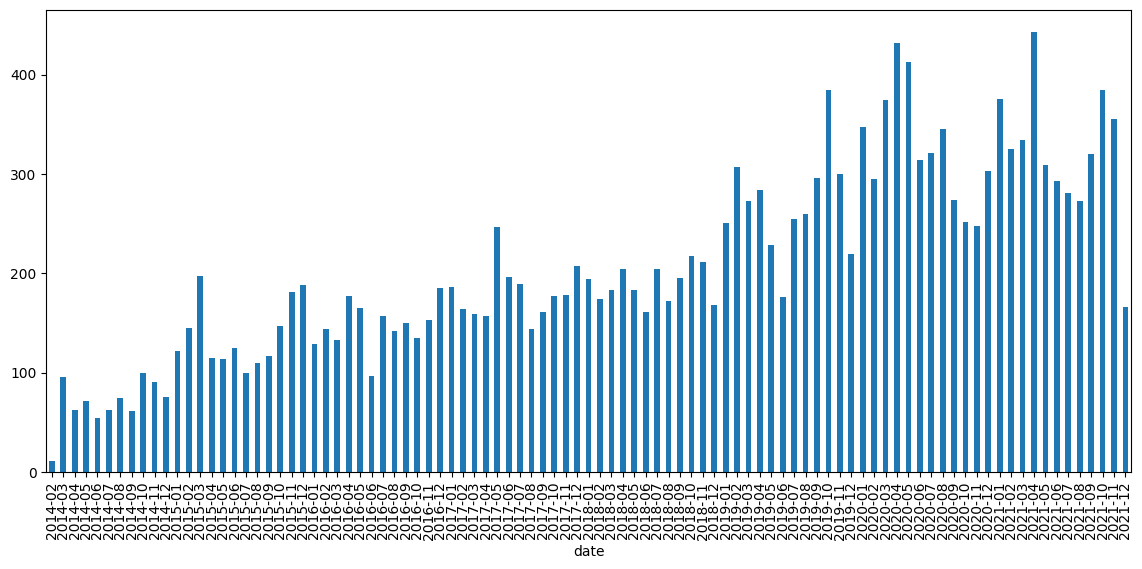

In [10]:
import pandas as pd
df = ds["train"].to_pandas()
# read "date" column as unix timestamp
df["date"] = pd.to_datetime(df["date"].astype(int), unit="s")
# plot entried per month as bars
df["date"].groupby(df["date"].dt.to_period("M")).count().plot(kind="bar", figsize=(14,6))

<Axes: xlabel='date'>

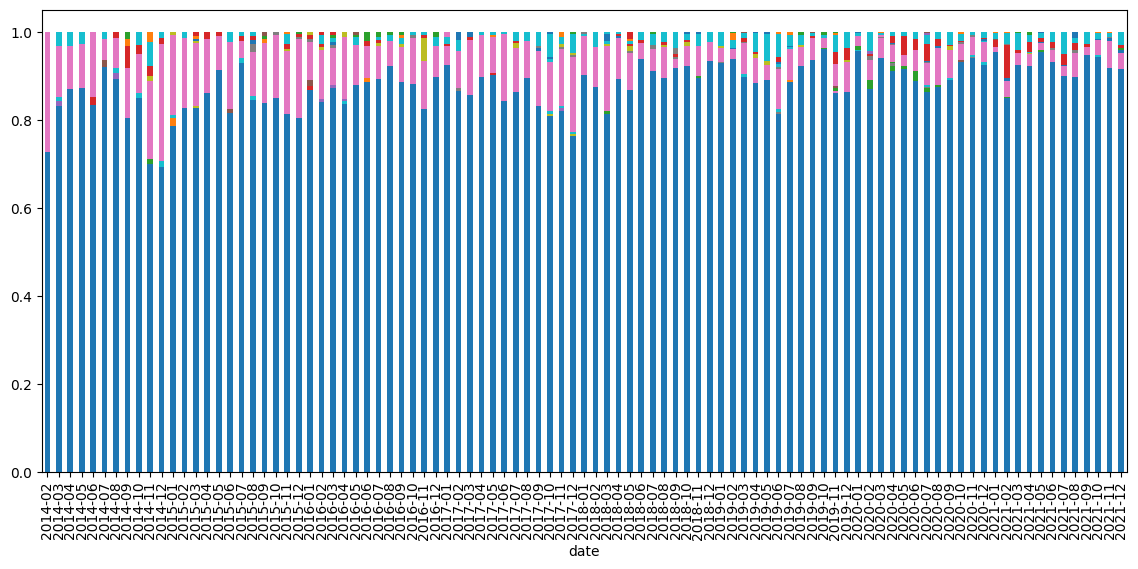

In [11]:
# plot stacked and streched bars of licenses per month
licenses = df["date"].groupby([df["date"].dt.to_period("M"), df["license"]]).count().unstack()
licenses = licenses.div(licenses.sum(axis=1), axis=0)
licenses.plot(kind="bar", stacked=True, figsize=(14,6), mark_right=True, legend=False)

<Axes: xlabel='date'>

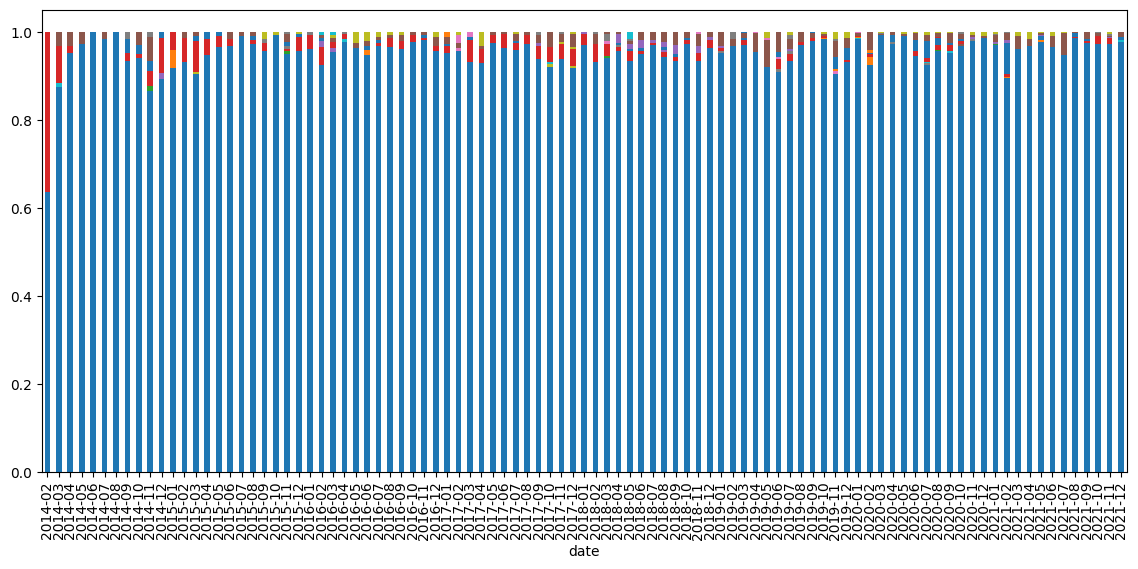

In [12]:
# variant where I check on the first comment (now includes multiline comments)
# plot stacked and streched bars of licenses per month
licenses = df["date"].groupby([df["date"].dt.to_period("M"), df["license2"]]).count().unstack()
licenses = licenses.div(licenses.sum(axis=1), axis=0)
licenses.plot(kind="bar", stacked=True, figsize=(14,6), mark_right=True, legend=False)

<Axes: xlabel='date'>

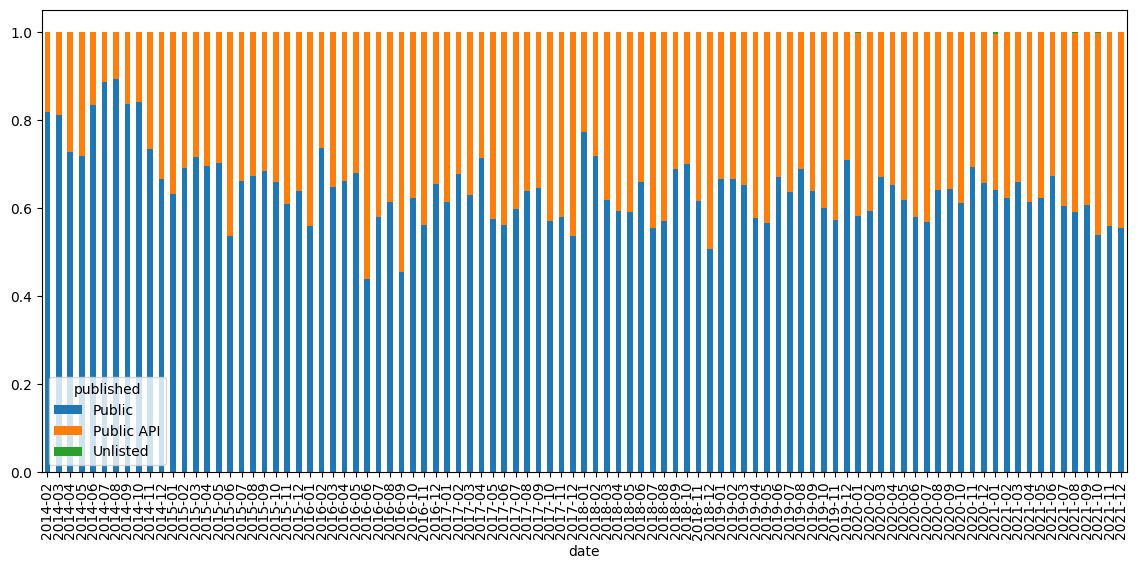

In [13]:
# plot stacked and streched bars of publishing privacy setting per month
privacies = df["date"].groupby([df["date"].dt.to_period("M"), df["published"]]).count().unstack()
privacies = privacies.div(privacies.sum(axis=1), axis=0)
privacies.plot(kind="bar", stacked=True, figsize=(14,6), mark_right=True, legend=True)

In [14]:
df["num_functions"] = df["functions"].apply(len)
df["num_functions"].describe()

count    19622.000000
mean         8.108450
std         10.439794
min          0.000000
25%          2.000000
50%          5.000000
75%         10.000000
max        358.000000
Name: num_functions, dtype: float64

In [15]:
df["functions"].head()

0    [[1, 1, 22, 22, 71], [73, 73, 94, 94, 143], [1...
1    [[517, 517, 598, 598, 673], [675, 675, 766, 76...
2    [[594, 1189, 1217, 1217, 1310], [1312, 1312, 1...
3        [[0, 0, 30, 30, 86], [88, 88, 145, 145, 816]]
4    [[262, 282, 303, 303, 717], [719, 719, 758, 75...
Name: functions, dtype: object

In [16]:
ds["train"]

Dataset({
    features: ['id', 'name', 'author', 'description', 'tags', 'likes', 'viewed', 'date', 'time_retrieved', 'image_code', 'image_inputs', 'common_code', 'sound_code', 'sound_inputs', 'buffer_a_code', 'buffer_a_inputs', 'buffer_b_code', 'buffer_b_inputs', 'buffer_c_code', 'buffer_c_inputs', 'buffer_d_code', 'buffer_d_inputs', 'cube_a_code', 'cube_a_inputs', 'license', 'thumbnail', 'access', 'wgpu-test', 'published', 'functions', 'license2'],
    num_rows: 19622
})

In [41]:
def split_functions(batch):
    comments, headers, docstrings, bodies = [],[],[],[]
    full_code, ids, func_ids, funcs = [],[],[],[]
    for code, func_bytes in zip(batch["image_code"], batch["functions"]):
        row_code = code.encode(encoding="utf-8")
        for start_comment, start_header, end_header, end_docstring, end_function in func_bytes:
            comments.append(row_code[start_comment:start_header].decode(encoding="utf-8")),
            headers.append(row_code[start_header:end_header].decode(encoding="utf-8")),
            docstrings.append(row_code[end_header:end_docstring].decode(encoding="utf-8")),
            bodies.append(row_code[end_docstring:end_function].decode(encoding="utf-8")),
            full_code.append(row_code.decode(encoding="utf-8")),
            funcs.append((start_comment, start_header, end_header, end_docstring, end_function))
    return {
            "comment": comments,
            "header": headers,
            "docstring": docstrings,
            "body": bodies,
            "full_code": full_code,
            "func_bytes": funcs
            }

func_ds = ds.map(split_functions, batched=True, remove_columns=ds["train"].column_names)
func_ds

Map:   0%|          | 0/19622 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['comment', 'header', 'docstring', 'body', 'full_code', 'func_bytes'],
        num_rows: 159104
    })
})

In [42]:
from typing import Counter
# what are the features?
def top_features(feature, k=10):
    feature_counter = Counter(func_ds["train"][feature])
    print(f"num non zero {feature}s: {len(func_ds['train']) - feature_counter['']}")
    return feature_counter.most_common(k)

top_features("header")

num non zero headers: 159104


[('void mainImage( out vec4 fragColor, in vec2 fragCoord )\n{', 12740),
 ('void mainImage( out vec4 fragColor, in vec2 fragCoord ) {', 1304),
 ('void mainImage(out vec4 fragColor, in vec2 fragCoord) {', 981),
 ('void mainImage(out vec4 fragColor, in vec2 fragCoord)\n{', 658),
 ('void mainImage( out vec4 fragColor, in vec2 fragCoord ){', 548),
 ('float sdBox( vec3 p, vec3 b )\n{', 515),
 ('float smin( float a, float b, float k )\n{', 352),
 ('vec3 ShowScene (vec3 ro, vec3 rd)\n{', 340),
 ('void mainImage (out vec4 fragColor, in vec2 fragCoord)\n{', 338),
 ('float ObjRay (vec3 ro, vec3 rd)\n{', 321)]

In [43]:
func_df = func_ds["train"].to_pandas()
func_df.head()

,comment,header,docstring,body,full_code,func_bytes
0,,vec3 mod289(vec3 x) {,,\n return x - floor(x * (1.0 / 289.0)) * 289....,\nvec3 mod289(vec3 x) {\n return x - floor(x ...,"[1, 1, 22, 22, 71]"
1,,vec2 mod289(vec2 x) {,,\n return x - floor(x * (1.0 / 289.0)) * 289....,\nvec3 mod289(vec3 x) {\n return x - floor(x ...,"[73, 73, 94, 94, 143]"
2,,vec4 mod289(vec4 x) {,,\n return x - floor(x * (1.0 / 289.0)) * 289....,\nvec3 mod289(vec3 x) {\n return x - floor(x ...,"[145, 145, 166, 166, 215]"
3,,vec4 permute(vec4 x) {,,\n return mod289(((x*34.0)+1.0)*x);\n},\nvec3 mod289(vec3 x) {\n return x - floor(x ...,"[217, 217, 239, 239, 279]"
4,,vec3 permute(vec3 x) {,,\n return mod289(((x*34.0)+1.0)*x);\n},\nvec3 mod289(vec3 x) {\n return x - floor(x ...,"[281, 281, 303, 303, 340]"


In [51]:
func_df["has_comment"] = func_df["comment"] != ""
func_df["has_docstring"] = func_df["docstring"] != ""
func_df["model_ctx"] = func_df["comment"] + func_df["header"] + func_df["comment"]
# how many functions are there, and what is the share of comments, 

xtab = pd.crosstab(func_df["has_comment"], func_df["has_docstring"], margins=True)
print(f"functions with context = {xtab.iloc[-1,-1] - xtab.iloc[0,0]}")
xtab

functions with context = 44551


has_docstring,False,True,All
has_comment,,,
False,114553,8405,122958
True,32081,4065,36146
All,146634,12470,159104


In [45]:
# FINDING: only about half the comments are unique.
# the most common ones look like padding (potential issue with multiline comments?)
print(func_df["comment"].nunique())
func_df["comment"].value_counts(sort=True, ascending=False).head(10)

19278


comment
                                                                                        122958
//---------------------------------------------------------\n                              130
//--------------------------------------------------------------------------\n             126
//\n                                                                                       114
//\n\n                                                                                     110
//------------------------------------------------------------------\n\n                   110
//////////////////////////////////////////////////////////\n\n                             105
/////////////////////////////////////////////////////////////////////////////\n            100
// http://iquilezles.org/www/articles/normalsSDF/normalsSDF.htm\n                           91
//------------------------------------------------------------------------------\n\n        91
Name: count, dtype: int64

In [48]:
# FINDING = only about a third of function-headers are unique?
print(func_df["header"].nunique())
func_df["header"].value_counts(sort=True, ascending=False).head(10)

64002


header
void mainImage( out vec4 fragColor, in vec2 fragCoord )\n{    12740
void mainImage( out vec4 fragColor, in vec2 fragCoord ) {      1304
void mainImage(out vec4 fragColor, in vec2 fragCoord) {         981
void mainImage(out vec4 fragColor, in vec2 fragCoord)\n{        658
void mainImage( out vec4 fragColor, in vec2 fragCoord ){        548
float sdBox( vec3 p, vec3 b )\n{                                515
float smin( float a, float b, float k )\n{                      352
vec3 ShowScene (vec3 ro, vec3 rd)\n{                            340
void mainImage (out vec4 fragColor, in vec2 fragCoord)\n{       338
float ObjRay (vec3 ro, vec3 rd)\n{                              321
Name: count, dtype: int64

In [50]:
# half the docstrings aren't unique?
# most common one is the shadertoy.com/new default for the main function
print(func_df["docstring"].nunique())
func_df["docstring"].value_counts(sort=True, ascending=False).head(10)

6461


docstring
                                                        146634
\n    // Normalized pixel coordinates (from 0 to 1)       1893
\n  // n must be normalized                                117
\n    // Based on gluLookAt man page                       112
\n    // c must be normalized                               95
\n    // Normalized pixel coordinates (from -1 to 1)        62
\n    // filter kernel                                      38
\n    // Add scaled noises                                  37
\n     // camera movement\t                                 35
\n    // preserve shape                                     33
Name: count, dtype: int64

In [54]:
# proposed model_ctx takes all of them in normal order (doens't filter out the naked functions)
print(func_df["model_ctx"].nunique())
func_df["model_ctx"].value_counts(sort=True, ascending=False).head(10)

73599


model_ctx
void mainImage( out vec4 fragColor, in vec2 fragCoord )\n{    11874
void mainImage( out vec4 fragColor, in vec2 fragCoord ) {      1122
void mainImage(out vec4 fragColor, in vec2 fragCoord) {         911
void mainImage(out vec4 fragColor, in vec2 fragCoord)\n{        585
void mainImage( out vec4 fragColor, in vec2 fragCoord ){        506
float sdBox( vec3 p, vec3 b )\n{                                369
vec3 ShowScene (vec3 ro, vec3 rd)\n{                            338
void mainImage (out vec4 fragColor, in vec2 fragCoord)\n{       335
float ObjRay (vec3 ro, vec3 rd)\n{                              320
vec3 ObjNf (vec3 p)\n{                                          318
Name: count, dtype: int64